# Practice Session 05: Hubs and authorities


In this session we will compute Hubs and Authorities using [NetworkX](https://networkx.github.io/), a Python package. This analysis is inspired by a paper on international trade ([Deguchi et al. 2014](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0100338)).

The dataset we will use comes from OECD's [trade in value by partner country](https://stats.oecd.org/Index.aspx?DataSetCode=PARTNER) dataset, and these are your input files:

* ``trade_1980-flows.csv.gz`` international trade in 1980
* ``trade_2013-flows.csv.gz`` international trade in 2013
* ``trade_2013-countries.csv.gz`` list of countries and territories

Plese note that the [HITS](https://en.wikipedia.org/wiki/HITS_algorithm) or hubs and authorities algorithm is implemented in NetworkX and elsewhere, but the other implementations follow a different design. Do this assignment on your own, following the design in this Notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

# 1. Read mapping of codes to country names

Read into variable ``id2name`` the file containing the list of countries and territories. 

This is a comma-separated file with two columns: *code*, which is a letter code (e.g. ``ZAF``),  and *name* (e.g., ``South Africa``).

You can use the following code snippet to read a compressed file:

```python
# Open a compressed file for reading in text mode
with gzip.open(FILENAME, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')
    
    # Iterate through records, each record is a dictionary
    for record in reader:
        print(record)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [1]:
import csv
import gzip
import io
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
INPUT_NAMES_FILENAME = "trade-countries.csv.gz"
INPUT_TRADE_1980 = "trade_1980-flows.csv.gz"
INPUT_TRADE_2013 = "trade_2013-flows.csv.gz"

# Organisation for Economic Co-operation and Development
OECD = set(["AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CZE", "DNK", "EST", "FIN", "FRA",
        "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", "KOR", "LVA", "LTU",
        "LUX", "MEX", "NLD", "NOR", "NZL", "POL", "CHE", "ESP", "GBR", "PRT", "SVK",
        "SVN", "SWE", "TUR", "USA"])

# BRICS = Brazil, Russia, India, China, and South Africa
# plus Argentina, Iran, Bangladesh, Egypt, the United Arab Emirates and Uruguay,
# See https://en.wikipedia.org/wiki/BRICS
BRICSP = set(["BRA", "RUS", "IND", "CHN", "ZAF", "ARG", "IRN", "BGD", "EGY", "ARE", "URY"])

# COUNTRIES
COUNTRIES = OECD.union(BRICSP)

In [3]:
id2name = {}

<font size="+1" color="red">Replace this cell with your code to read country names into id2name.</font>

Test the mapping using the following code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [5]:
# LEAVE AS-IS

print(id2name["URY"])

Uruguay


# 2. Read flows data into two graphs

## 2.1. Read amount traded

Read the graphs as directed graphs into variables `g_old` (1980 data) and `g_new` (2013 data).

You can create an empty graph using:

```python
g = nx.DiGraph()
```

In some rows the `amount` is empty. Hence, you will have to consider those as zeroes. You can do, for instance: `amount = float(record["amount"]) if len(record["amount"]) > 0 else 0.0`. Divide the amounts by one million and round to the nearest integer, so the weights will be expressed in millions of dollars.

Add only the edges that describe a trade amount that is non-zero (i.e., more than half a million dollars), and that involve OECD or BRICS countries; we do not care if the country is OECD or BRICS, but the country must belong to one of those groups to be included in the graph. If the input contains self-loops, ignore them.

If the flow is "Import", add an edge from *country2* to *country1*. If the flow is "Export", add an edge from *country1* to *country2*.

To add a weighted edge in *g* from node *u* to node *v* with weight *w*, use `g.add_edge(u, v, weight=w)`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to read the two graphs. Read the 1980 trade graph into variable g1980, read the 2013 graph into variable g2013.</font>

The following should print:

```
In 1980, ZAF (South Africa) exported to FRA (France) goods and services for 100 USD millions
by 2013, it exported 89 USD millions

In 1980, ZAF (South Africa) exported to DEU (Germany) goods and services for 112 USD millions
by 2013, it exported 524 USD millions

In 1980, ARG (Argentina) exported to FRA (France) goods and services for 25 USD millions
by 2013, it exported 51 USD millions

In 1980, ARG (Argentina) exported to DEU (Germany) goods and services for 59 USD millions
by 2013, it exported 185 USD millions

```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [7]:
# LEAVE AS-IS

for exporter in ["ZAF", "ARG"]:
    for importer in ["FRA", "DEU"]:
        print("In 1980, {:s} ({:s}) exported to {:s} ({:s}) goods and services for {:,d} USD millions".format(
            exporter, id2name[exporter], importer, id2name[importer],
               g1980.get_edge_data(exporter, importer)["weight"]) )

        print("by 2013, it exported {:,d} USD millions".format(g2013.get_edge_data(exporter, importer)["weight"]))
        print("")
    

In 1980, ZAF (South Africa) exported to FRA (France) goods and services for 100 USD millions
by 2013, it exported 89 USD millions

In 1980, ZAF (South Africa) exported to DEU (Germany) goods and services for 112 USD millions
by 2013, it exported 524 USD millions

In 1980, ARG (Argentina) exported to FRA (France) goods and services for 25 USD millions
by 2013, it exported 51 USD millions

In 1980, ARG (Argentina) exported to DEU (Germany) goods and services for 59 USD millions
by 2013, it exported 185 USD millions



## 2.2. Compute totals

Next, compute the total exports of each country, into two dictionaries: `exports1980` and `exports2013`, with keys being country codes, and values being total exports. Do the same with total imports, into variables `imports1980` and `exports2013`.

To iterate through the nodes of a graph, you can use:

```python
for n in g.nodes():
    # n is the name of the node
```

To iterate through the edges of a graph, you can use:

```python
for u, v, d in g.edges(data=True):
    w = d['weight']
    # u is the source, v the destination, w the weight
```

To create a dictionary `d` initialized so that all keys are the elements of set `s` and all values are zero:

```python
d = dict([(element,0) for element in s])
```

To avoid code duplication, create a function `sum_weights(graph, direction, weight_key)` to avoid duplication. This function should receive a *graph*, a *direction* ("in" or "out"), and a *weight_key*, defaulting to "weight".

    
<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to compute total exports into dictionaries exports1980, exports2013, imports1980, imports2013. Create a function *sum_weights* to avoid code duplication.</font>

The following should print:

```
United States exported 15,872 USD Million in 1980 and 98,827 USD Million in 2013 (growth 6.2x),
 and imported 12,724 USD Million in 1980 and 158,024 USD Million in 2013 (growth 12.4x).

Argentina exported 330 USD Million in 1980 and 1,977 USD Million in 2013 (growth 6.0x),
 and imported 640 USD Million in 1980 and 2,285 USD Million in 2013 (growth 3.6x).

Iran exported 845 USD Million in 1980 and 1,532 USD Million in 2013 (growth 1.8x),
 and imported 614 USD Million in 1980 and 960 USD Million in 2013 (growth 1.6x).

China (People's Republic of) exported 715 USD Million in 1980 and 100,868 USD Million in 2013 (growth 141.1x),
 and imported 1,100 USD Million in 1980 and 49,216 USD Million in 2013 (growth 44.7x).
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [9]:
# LEAVE AS-IS

for country in ['USA', 'ARG', 'IRN', 'CHN']:
    print("{:s} exported {:,d} USD Million in 1980 and {:,d} USD Million in 2013 (growth {:.1f}x),".format(
        id2name[country], exports1980[country], exports2013[country], exports2013[country]/exports1980[country]
    ))
    print(" and imported {:,d} USD Million in 1980 and {:,d} USD Million in 2013 (growth {:.1f}x).".format(
        imports1980[country], imports2013[country], imports2013[country]/imports1980[country]
    ))
    print()

United States exported 15,872 USD Million in 1980 and 98,827 USD Million in 2013 (growth 6.2x),
 and imported 12,724 USD Million in 1980 and 158,024 USD Million in 2013 (growth 12.4x).

Argentina exported 330 USD Million in 1980 and 1,977 USD Million in 2013 (growth 6.0x),
 and imported 640 USD Million in 1980 and 2,285 USD Million in 2013 (growth 3.6x).

Iran exported 845 USD Million in 1980 and 1,532 USD Million in 2013 (growth 1.8x),
 and imported 614 USD Million in 1980 and 960 USD Million in 2013 (growth 1.6x).

China (People's Republic of) exported 715 USD Million in 1980 and 100,868 USD Million in 2013 (growth 141.1x),
 and imported 1,100 USD Million in 1980 and 49,216 USD Million in 2013 (growth 44.7x).



The code below, which you should use as-is, converts the imports and exports into a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [10]:
# LEAVE AS-IS

sorted_countries = sorted(COUNTRIES)

flowsData = {
    'exp1980': [(exports1980[c] if c in exports1980 else 0) for c in sorted_countries],
    'imp1980': [(imports1980[c] if c in imports1980 else 0) for c in sorted_countries],
    'exp2013': [(exports2013[c] if c in exports2013 else 0) for c in sorted_countries], 
    'imp2013': [(imports2013[c] if c in imports2013 else 0) for c in sorted_countries],
}

flowsDF = pd.DataFrame(flowsData, index=sorted_countries)
flowsDF

,exp1980,imp1980,exp2013,imp2013
ARE,1510,463,5717,7925
ARG,330,640,1977,2285
AUS,1347,1308,16945,13754
AUT,1212,1696,12465,13133
BEL,4331,4876,35176,34469
BGD,38,100,2071,430
BRA,1078,873,8069,9519
CAN,4874,4338,36490,34643
CHE,2179,2869,16784,16848
CHL,259,246,5645,5509


# 3. Draw the exports graphs

Draw the two graphs using NetworkX. Define an auxiliary function named `plotGraph(graph, exports)` for this, and use it to plot both graphs.

You can adapt the following code snippet. If `g` is a NetworkX graph in which weights are expressed in the variable *weight*, the following layouts a graph using a spring model. The constants *NODE_SIZE_MULTIPLIER* and *EDGE_WIDTH_MULTIPLIER* should be numbers smaller than zero used to reduce the node sizes and edge widths to a manegeable size (set by trial and error).

```python
    plt.figure(figsize=(20,12))
    
    # Compute node sizes as a function of total exports
    node_sizes = []
    for node in g.nodes():
        node_sizes.append(exports[node] * NODE_SIZE_MULTIPLIER)

    # Compute edge widths as a function of exports
    edge_widths = []
    for u, v, d in g.edges(data=True):
        weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
        edge_widths.append(weight)
        
    # Determine node positions
    pos = nx.spring_layout(g, iterations=100, weight="weight")
    
    # Draw nodes
    nx.draw_networkx_nodes(g, pos, node_color="yellow", node_size=node_sizes)

    # Draw edges
    nx.draw_networkx_edges(g, pos, width=edge_widths, )

    # Draw labels and display graph
    _ = nx.draw_networkx_labels(g, pos)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to plot the two graphs.</font>

<font size="+1" color="red">Replace this cell with a brief commentary on what are the similarities and differences you observe between these two graphs.</font>

# 4. Compute hubs and authorities

Implement the iterative algorithm seen in class for hubs and authorities. Instead of vectors, we will use two dictionaries having country names as keys. Dictionary `h` should contain the hub scores, while dictionary `a` should contain the authority scores.

Start from normalized hub scores: the hub score should be *1/N* for each country, where *N* is the number of countries.

Then, perform 100 iterations of the following:

1. Compute authority scores from hub scores (weighted sum of hub scores of incoming links times edge weights)
1. Normalize the authority scores.
1. Compute hub scores from authority scores (weighted sum of auhority scores of outgoing links times edge weights)
1. Normalize the hub scores.

Create two functions: `normalize(d)` that sums the values of a dictionary and then divides each one by the sum, returning the resulting dictionary, and `hubs_authorities(g, weight_key="weight")` that computes hubs and authorities using by default the edge key "weight" as a weight.

Notes:
1. You do *not* need to normalize edge weights.
1. It is OK if for countries that have no data (e.g., Estonia in 1980) some scores are NaN.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for function *normalize*</font>

The following should print:
    
```python
{'a': 0.5, 'b': 0.16666666666666666, 'c': 0.3333333333333333}```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [13]:
# LEAVE AS-IS

print(normalize({"a": 39, "b": 13, "c":26}))

{'a': 0.5, 'b': 0.16666666666666666, 'c': 0.3333333333333333}


<font size="+1" color="red">Replace this cell with your code for function *hubs_authorities(graph, weight_key="weight")*. Remember to include comments to explain what your code does at every relevant step.</font>

In [15]:
# LEAVE AS-IS
# Execution should be very fast (a few seconds maximum)

print("Computing for 1980")
(h1980,a1980) = hubs_authorities(g1980)

print("Computing for 2013")
(h2013,a2013) = hubs_authorities(g2013)

Computing for 1980
Computing for 2013


In [16]:
# LEAVE AS-IS

flowsDF['h1980'] = pd.Series(h1980)
flowsDF['a1980'] = pd.Series(a1980)
flowsDF['h2013'] = pd.Series(h2013)
flowsDF['a2013'] = pd.Series(a2013)

flowsDF

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
ARE,1510,463,5717,7925,0.016822,0.005541,0.005204,0.006504
ARG,330,640,1977,2285,0.003986,0.008865,0.002373,0.002140
AUS,1347,1308,16945,13754,0.012905,0.015936,0.012657,0.021904
AUT,1212,1696,12465,13133,0.013344,0.020639,0.009377,0.013602
BEL,4331,4876,35176,34469,0.053995,0.059734,0.025724,0.027713
BGD,38,100,2071,430,0.000466,0.001249,0.002791,0.000418
BRA,1078,873,8069,9519,0.013615,0.013042,0.012940,0.008761
CAN,4874,4338,36490,34643,0.074716,0.079019,0.124175,0.045189
CHE,2179,2869,16784,16848,0.023722,0.032668,0.017403,0.017149
CHL,259,246,5645,5509,0.003308,0.003706,0.006034,0.008106


Print the top 5 countries by exports and by hub score in 2013.

You can use a command like this: `display(dataframe.sort_values(by=colname, ascending=False).head(numrows))`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with commands to print top countries by exports and by hub score.</font>

<font size="+1" color="red">Replace this cell with a brief commentary in which you compare the two lists above. Explain clearly what does it mean to be a country with high hub score versus being a country with high total exports.</font>

Print the top 5 countries by imports and by authority score in 2013.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with commands to print top countries by imports and by authority score.</font>

<font size="+1" color="red">Replace this cell with a brief commentary in which you compare the two lists above. Explain clearly what does it mean to be a country with high authority score versus being a country with high total imports.</font>

# 5. Comparison of hub/export, authority/import scores

Now, we will compare the hub score of a country against its exports, and the authority scores of a country against its imports.

We can do this visually by plotting both in log-log scale. You can use the following code snippet, which assumes we are plotting dictionary *a* against dictionary *b*:

```python
# Create log-log plot
plt.figure(figsize=(20,10))
plt.loglog()
plt.xlabel("x axis label", {'size': '22'})
plt.xlabel("y axis label", {'size': '22'})

# Add a diagonal line
plt.plot([min(a.values()),max(a.values())], [min(b.values()),max(b.values())], '-.', lw=2)

# Do the scatter plot with texts
for country in set(a.keys()).intersection(set(b.keys())):
    plt.text(a[country], b[country], country, {'size': '12'})
```

Remember to add labels to the x axis and y axis before delivering your plots, and to use a function (name it `plot_scatter`) to draw your plots: do not duplicate code.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your function *plot_scatter*.</font>

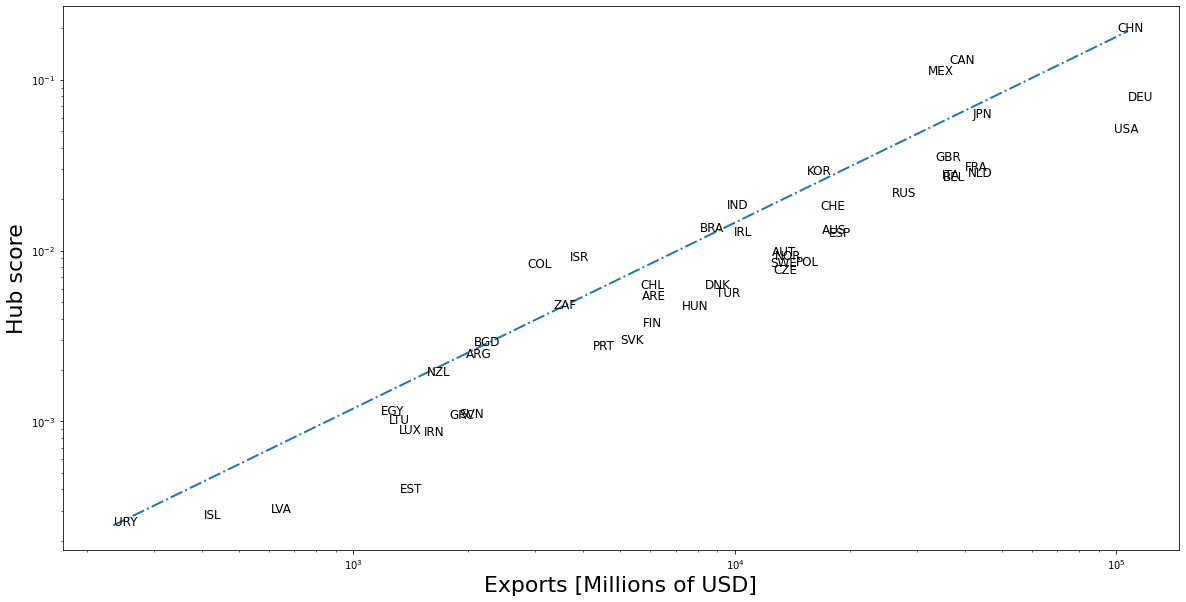

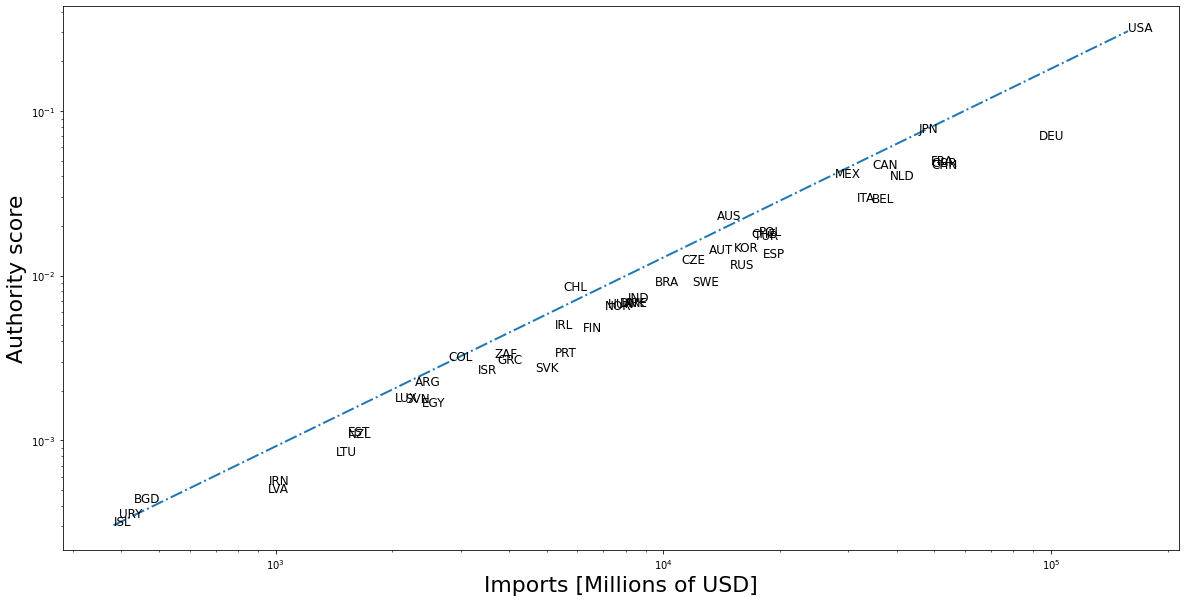

In [22]:
# LEAVE AS-IS: print plots for 2013

plot_scatter( exports2013, h2013, "Exports [Millions of USD]", "Hub score" )
plot_scatter( imports2013, a2013, "Imports [Millions of USD]", "Authority score" )

<font size="+1" color="red">Replace this cell with a brief commentary about the plots above with respect to (a) Hub scores versus exports, and (b) Authority scores versus imports.</font>

# DELIVER (individually)

A .zip file containing:

* This notebook.


## Extra points available

For extra points and extra learning (+2, so your maximum grade can be a 12 in this assignment), export this network to .csv, export the hub scores to a separate .csv file, and import both in Cytoscape. Then, do a clustering analysis in Cytoscape, paint the clusters with colors, resize nodes according to hub scores, and insert the image on this Notebook, with a brief commentary.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: country clusters</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>